In [1]:
import numpy as np
import pandas as pd
import os, re, glob
from itertools import chain
import matplotlib.pyplot as plt
import jiwer

from util.helpers import create_directory


from config.constants import Constants
CONSTANTS = Constants(local=True)


## Get mapping of sample name to label -> for group-wise analysis later

In [2]:
from dataloader.metadata_loader import ADReSSParticipantMetadataLoader

metadata_loader = ADReSSParticipantMetadataLoader()
metadata = metadata_loader.load_metadata()
metadata

Initializing metadata loader ADReSS Participant Metadata


/Users/jheitz/git/coling2025_gpt_paper/src/dataloader/metadata_loader.py:39: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  self.metadata.mmse = self.metadata.mmse.astype('str').str.strip().replace('NA', ).dropna().astype(int)


,sample_name,age,gender,Label,mmse
0,S160,63,1,0,28
1,S161,55,1,0,29
2,S162,67,1,1,24
3,S163,71,0,0,30
4,S164,73,1,1,21
...,...,...,...,...,...
49,S071,74,0,0,29
50,S072,75,0,0,29
51,S073,61,0,0,29
52,S076,78,1,0,28


## Load preprocessed manual transcripts


In [3]:

def get_manual_transcriptions():
    transcriptions = []

    for root, dirs, files in os.walk('/Volumes/methlab/Students/Jonathan/data_preprocessed/transcriptions/manual/_raw_ADReSS_manual_transcripts/ee5faf'):
        # Filter the files for .txt extension
        txt_files = glob.glob(os.path.join(root, '*.txt'))

        # Read the content of each .txt file
        for file_path in txt_files:
            
            with open(file_path, 'r') as file:
                content = file.read()
                path = os.path.basename(file_path)
                sample_name = path[:path.index(".")]
                if sample_name != "info":
                    transcriptions.append(pd.Series({'file': path, 'sample_name': sample_name, 'manual': content}))

    return pd.concat(transcriptions, axis=1).T

manual = get_manual_transcriptions()
manual

file sample_name                                             manual

[156 rows x 3 columns]

## Load different ASR transcriptions

In [4]:
def get_ASR_transcriptions(base_dirs, manual, version_name):
    transcriptions = []

    # Traverse the directory and its subdirectories
    for root, dirs, files in chain.from_iterable(os.walk(d) for d in base_dirs):
        # Filter the files for .txt extension
        txt_files = glob.glob(os.path.join(root, '*.txt'))
        #print(sorted([os.path.basename(f) for f in txt_files]), len([os.path.basename(f) for f in txt_files]))

        # Read the content of each .txt file
        for file_path in txt_files:

            with open(file_path, 'r') as file:
                content = file.read()
                try:
                    # remove metadata at beginning of file by splitting by double line break and taking the second part, if available
                    content = content[content.index("\n\n")+2:]
                except:
                    pass
                # remove punctuation
                content = re.sub(r"[.,?!]", "", content)
                # normalize white spaces
                content = re.sub(r"\s+", " ", content).strip()
                content = content.lower()
                path = os.path.basename(file_path)
                sample_name = path[:path.index(".")]
                if sample_name != "info":
                    transcriptions.append(pd.Series({'file': path, 'sample_name': sample_name, 'transcript': content, 'version': version_name}))

    concat = pd.concat(transcriptions, axis=1).T
    return concat.merge(manual.drop(columns=["file"]), on="sample_name", how="outer")


In [5]:
# Load Google Speech
google = get_ASR_transcriptions([f'/Volumes/methlab/Students/Jonathan/data_preprocessed/transcriptions/google_speech/v1_9ae494/{d}' for d in ['_raw_ADReSS_audio_test_-_Audio_Cutter', '_raw_ADReSS_audio_train_-_Audio_Cutter']], manual, "google")
google

file sample_name                                         transcript  \

    version                                             manual  

[156 rows x 5 columns]

In [6]:
whisper = get_ASR_transcriptions([f'/Volumes/methlab/Students/Jonathan/data_preprocessed/transcriptions/whisper-large/v2_7e8484/{d}' for d in ['_raw_ADReSS_audio_test_-_Audio_Cutter', '_raw_ADReSS_audio_train_-_Audio_Cutter']], manual, "whisper")
whisper

file sample_name                                         transcript  \

     version                                             manual  

[156 rows x 5 columns]

## Calculate Word Error Rate (WER)

Using jiwer package, also CER, which we don't use...

In [7]:
def calculate_wer(transcription):
    def calculate_row(fct, row):
        try:
            return fct(row.manual, row.transcript)
        except:
            return None
    transcription['WER'] = transcription.apply(lambda row: calculate_row(jiwer.wer, row), axis=1)  # word error rate
    transcription['CER'] = transcription.apply(lambda row: calculate_row(jiwer.cer, row), axis=1)  # character error rate
    return transcription


In [8]:
# Example, for one ASR
with pd.option_context('display.max_colwidth', 2000):
    display(calculate_wer(whisper))

file sample_name  \
0    S193.txt        S193   
1    S194.txt        S194   
2    S170.txt        S170   
3    S177.txt        S177   
4    S179.txt        S179   
..        ...         ...   
151  S004.txt        S004   
152  S003.txt        S003   
153  S036.txt        S036   
154  S043.txt        S043   
155  S038.txt        S038   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 transcript  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   okay the kid on the bench who's got his hand in the cookie jar and he's falling off his sister wants one his mother is standing in a puddle of water because she didn't turn off the faucet and she's trying to dry a dish she ought to dry her feet instead the window is open the water sink is overflowing it's obviously summer because the window as i said was open there's supposedly leaves on the trees anything else that i'm supposed to pick up well the kid's going to fall off the lid is off the cookie jar he's got one in his hand handing it to his sister and one is sneaking another one not sneaking the water is still running in the sink and splashing on the floor there we go   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

### Plot box plot of distribution of WER for each ASR sytem

With and without outliers

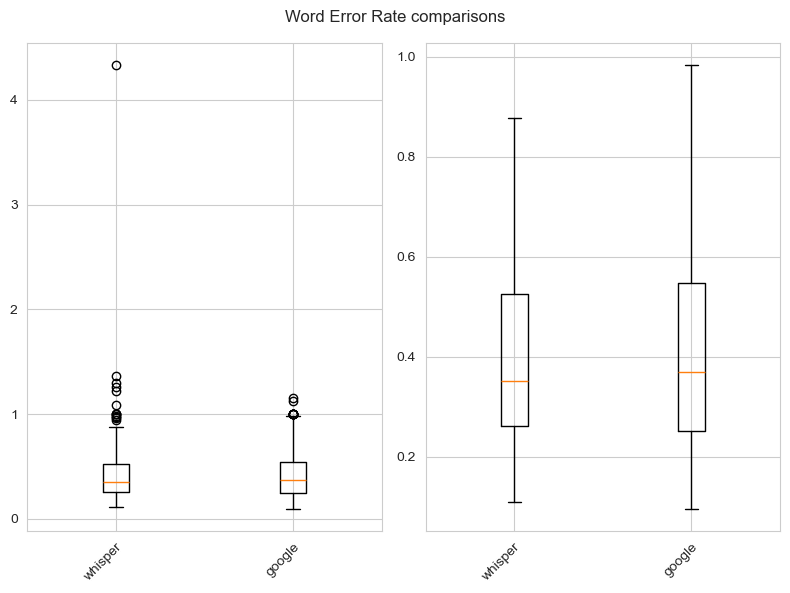

In [9]:
def plot_metrics(metric_name, experiment_name, *transcriptions):

    metric_name_mapping = {
        'WER': "Word Error Rate",
        'CER': "Character Error Rate"
    }
    metric_name_full = metric_name_mapping.get(metric_name, metric_name)

    metrics = {}
    for t in transcriptions:
        version = t['version'][0]
        #print("Version:", version)
        if t.query("transcript.isna()").shape[0] > 0:
            print(f"NA transcriptions for sample {t.query('transcript.isna()')['sample_name']}")
            t = t.query("not transcript.isna()").copy()
        m = calculate_wer(t)[metric_name]
        metrics[version] = m

    # positions: i + a gap between each group. Make sure it's sorted by group, otherwise the positions logic doesnt work
    groups = [0 if 'adress' in metric_name else 1 for metric_name in metrics]
    assert sorted(groups) == groups
    positions = [i+groups[i] for i in range(len(groups))]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6))
    fig.suptitle(f'{metric_name_full} comparisons')
    ax1.boxplot(metrics.values(), positions=positions)
    ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right', rotation_mode='anchor')
    ax2.boxplot(metrics.values(), sym="", positions=positions)
    ax2.set_xticklabels(metrics.keys(), rotation=45, ha='right', rotation_mode='anchor')
    plt.tight_layout()

    create_directory("plots")
    experiment_name_part = experiment_name.replace(" ", "_").lower()
    plt.savefig(f"plots/{experiment_name_part}_{metric_name}-transcriptions.png")
    plt.show()

plot_metrics('WER', 'ASR comparison', whisper, google)
#plot_metrics('CER', 'ASR comparison', whisper, google, wave2vec2)





## Load gender and age information for each sample_name

In [10]:
# get gender and age

metadata_raw = [{'path': os.path.join(CONSTANTS.DATA_ADReSS_ROOT, "test", "meta_data_with_labels.csv"), 'label': None},
                {'path': os.path.join(CONSTANTS.DATA_ADReSS_ROOT, "train", "cd_meta_data.txt"), 'label': 1},
                {'path': os.path.join(CONSTANTS.DATA_ADReSS_ROOT, "train", "cc_meta_data.txt"), 'label': 0}]

dfs = []
for d in metadata_raw:
    path, label = d['path'], d['label']
    df = pd.read_csv(path, sep=";")
    if label is not None:
        df['Label'] = label
    df = df.rename(columns={c: c.strip() for c in df.columns}).rename(columns={'ID': 'sample_name'})
    dfs.append(df)
participant_metadata = pd.concat(dfs)
participant_metadata.sample_name = participant_metadata.sample_name.str.strip()
participant_metadata.gender = np.where(participant_metadata.gender.str.strip().isin(['female', "1", 1]), 1, np.where(participant_metadata.gender.str.strip().isin(['male', "0", 0]), 0, participant_metadata.gender)) # 1 female, 0 male
participant_metadata

participant_metadata.gender.value_counts(dropna=False)

gender
1    86
0    70
Name: count, dtype: int64

## Plot distribution of WER for each ASR and group

In [11]:
combined = pd.concat([whisper, google])
combined = combined.sort_values(by="file").drop(columns=['transcript','manual'])
combined = combined.merge(participant_metadata, on="sample_name", how="left")
combined['Label'] = combined['Label'].astype(str)
combined

,file,sample_name,version,WER,CER,age,gender,Label,mmse
0,S001.txt,S001,whisper,0.198068,0.097586,74,0,0,NA
1,S001.txt,S001,google,0.193237,0.089537,74,0,0,NA
2,S002.txt,S002,whisper,0.873786,0.599617,62,1,0,30
3,S002.txt,S002,google,1.000000,1.000000,62,1,0,30
4,S003.txt,S003,google,0.248447,0.143421,69,1,0,29
...,...,...,...,...,...,...,...,...,...
307,S205.txt,S205,google,0.190476,0.089404,50,0,1,23
308,S206.txt,S206,whisper,0.141667,0.056042,65,0,0,28
309,S206.txt,S206,google,0.125000,0.052539,65,0,0,28
310,S207.txt,S207,google,1.122449,0.879668,57,1,0,27


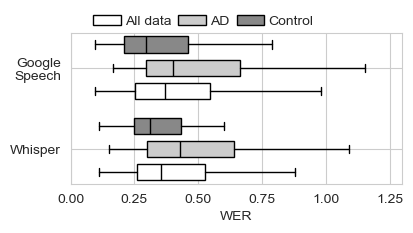

In [12]:
import matplotlib.patches as mpatches

def plot_metrics_for_paper2(combined):


    #with plt.rc_context({"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": "Arial", "font.size": 10}):
    with plt.rc_context({"font.family": "sans-serif", "font.sans-serif": "Arial", "font.size": 10}):
        # one column is 7.7 cm
        cm = 1/2.54
        fig, (ax2) = plt.subplots(1, 1, figsize=(7.7*1.3*cm,5.5*cm))
        #fig.suptitle(f'{metric_name_full} comparisons')


        label_positions = []
        labels = []
        for subgroup in ['all', 'dementia', 'control']:
            for i, version in enumerate(combined.version.drop_duplicates()):
                base_position = i*3.5
                if subgroup == 'all':
                    values = combined.query(f"version == '{version}'").WER
                    position = base_position
                    boxprops = dict(facecolor='#fff')
                    label_positions.append(base_position + 1)
                    labels.append(version.replace("_adress", "").replace("wave2vec2", 'Wave2vec2').replace("google", 'Google\nSpeech').replace("whisper", 'Whisper'))
                elif subgroup == 'dementia':
                    values = combined.query(f"version == '{version}' and Label == '1'").WER
                    position = base_position + 1
                    boxprops = dict(facecolor='#ccc')
                elif subgroup == 'control':
                    values = combined.query(f"version == '{version}' and Label == '0'").WER
                    position = base_position + 2
                    boxprops = dict(facecolor='#888')
                ax2.boxplot(values, sym="", positions=[position], vert=False, widths=0.7, boxprops=boxprops, medianprops=dict(color='#000'), patch_artist=True)

                #ax2.text(1.27, position-0.1, f"{np.median(values):.2f}", ha="right", va="center", fontsize="9", backgroundcolor="white", linespacing=1,
                #          bbox=dict(boxstyle='square,pad=-0.1', fc=(1,1,1,0.7), ec="none"))

        # custom legend
        all = mpatches.Patch(facecolor='#fff', edgecolor='#000', label='All data')
        dementia = mpatches.Patch(facecolor='#ccc', edgecolor='#000', label='AD')
        control = mpatches.Patch(facecolor='#888', edgecolor='#000', label='Control')
        plt.legend(handles=[all, dementia, control], fontsize=10, ncol=3, loc='upper center', bbox_to_anchor=(0.4,1.2), columnspacing=0.5, frameon=False, handletextpad=0.3)


        ax2.set_xlabel("WER")
        ax2.set_yticks(label_positions, labels)#, rotation=45, ha='right', rotation_mode='anchor')
        ax2.set_xticks([0, .25, .5, .75, 1, 1.25])
        ax2.set_xlim([0,1.3])
        plt.tight_layout(pad=0)

        plt.savefig(f"plots/ASR_WER_with_subgroups2.pdf")
        plt.show()

plot_metrics_for_paper2(combined)

In [13]:
combined.groupby('version').WER.agg(['mean', 'median'])

,mean,median
version,,
google,0.444046,0.368993
whisper,0.464209,0.352759


In [14]:
combined.groupby(['version', 'Label']).WER.agg(['mean', 'median'])


mean    median
version Label                    
google  0      0.392843  0.297084
        1      0.495249  0.399456
whisper 0      0.434361  0.310912
        1      0.494057  0.427146